In [114]:
import pymc3 as pm
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

# Splitting data into training/testing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

# Distributions
import scipy
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
edf = pd.read_csv('final_data.csv')

In [13]:
edf.columns

Index(['Unnamed: 0', 'MajorN', 'OthN', 'NoCrimN', 'PropN', 'VioN',
       'AvgOfMajorN', 'AvgOfOthN', 'AvgOfNoCrimN', 'AvgOfPropN', 'AvgOfVioN',
       'asthmaRatio', 'drugsRatio', 'SATmath', 'SATall', 'index',
       'mean_income'],
      dtype='object')

In [17]:
edf.drop(['Unnamed: 0', 'SATmath','index'],axis=1,inplace=True)

In [20]:
label = edf['SATall']
dataset = edf.loc[:, edf.columns != 'SATall']


In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(edf, label, 
                                                   test_size = 0.25,
                                                    random_state=42)


In [25]:
formula='SATall ~ MajorN + OthN  + NoCrimN  + PropN + VioN + AvgOfMajorN +  AvgOfOthN  + AvgOfNoCrimN  + AvgOfPropN + AvgOfVioN + asthmaRatio + drugsRatio + mean_income'

In [26]:
with pm.Model() as normal_model:
    
    # The prior for the data likelihood is a Normal Distribution
    family = pm.glm.families.Normal()
    
    # Creating the model requires a formula and data (and optionally a family)
    pm.GLM.from_formula(formula, data = X_train, family = family)
    
    # Perform Markov Chain Monte Carlo sampling letting PyMC3 choose the algorithm
    normal_trace = pm.sample(draws=2000, chains = 2, tune = 500, njobs=-1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, mean_income, drugsRatio, asthmaRatio, AvgOfVioN, AvgOfPropN, AvgOfNoCrimN, AvgOfOthN, AvgOfMajorN, VioN, PropN, NoCrimN, OthN, MajorN, Intercept]
100%|██████████| 2500/2500 [03:47<00:00, 10.99it/s]
There were 181 divergences after tuning. Increase `target_accept` or reparameterize.
There were 244 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa1cc036898>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fa1cf14cf60>]], dtype=object)

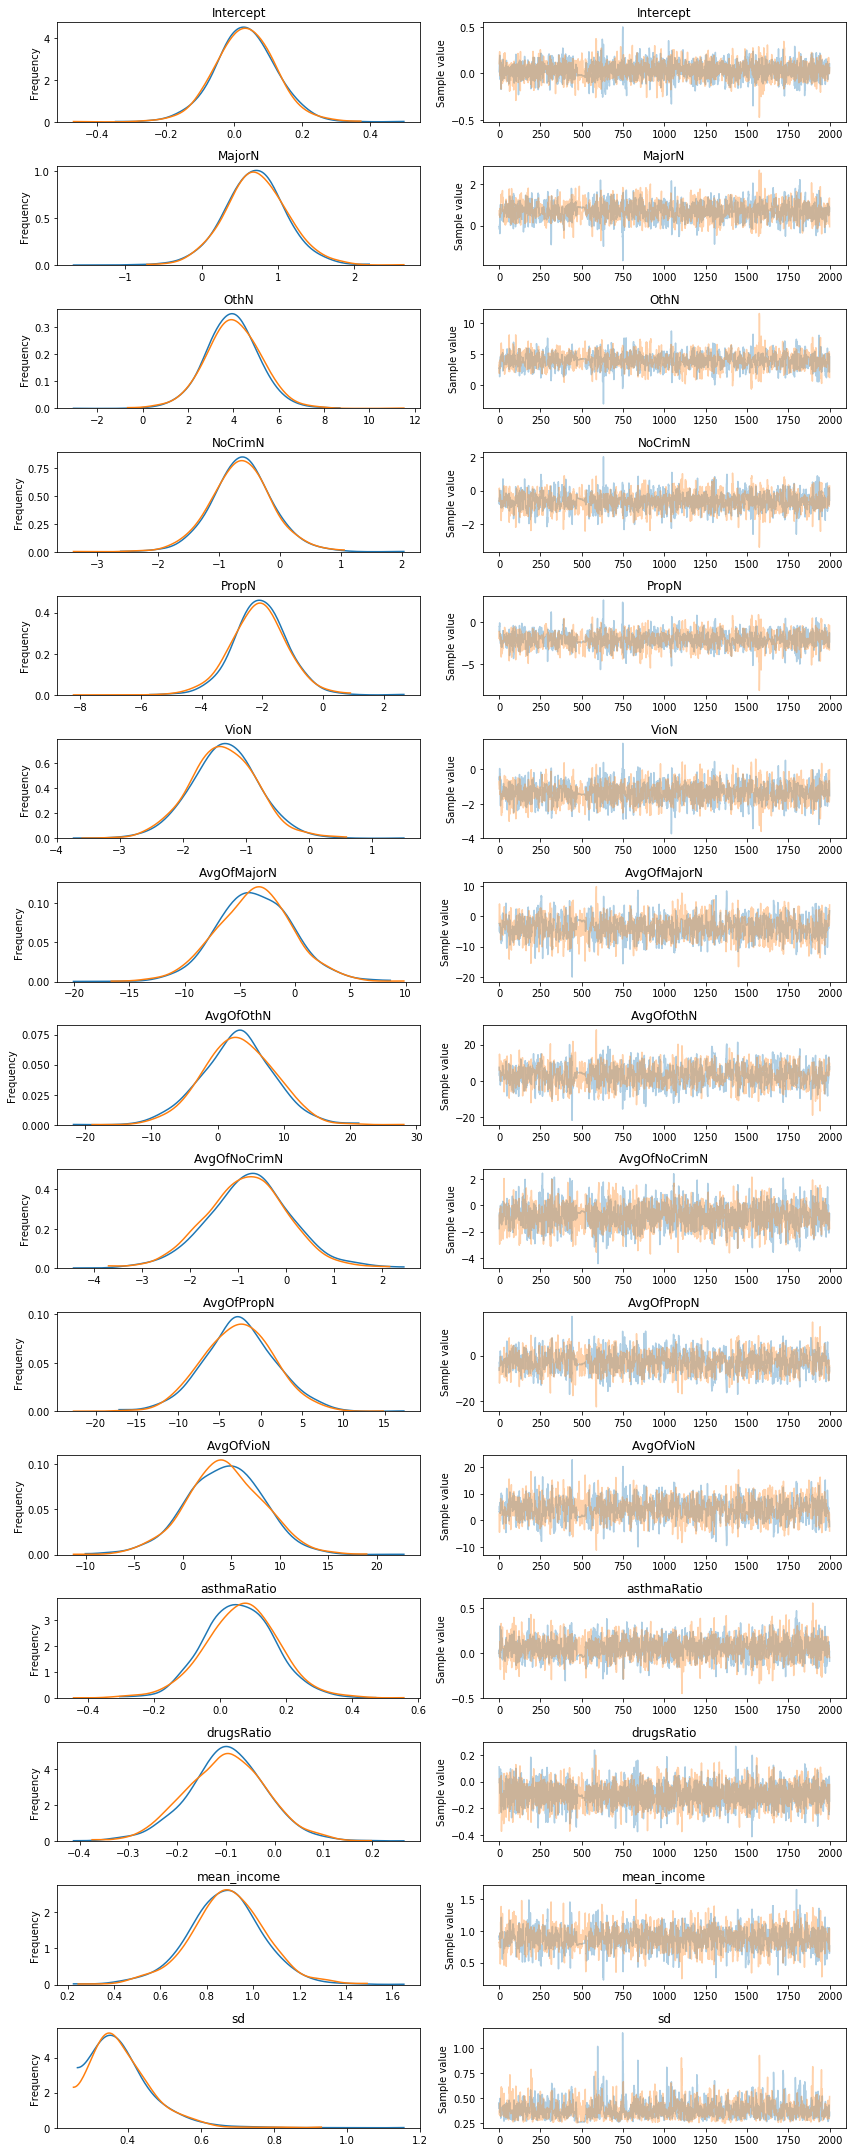

In [28]:
pm.traceplot(normal_trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa1c7955978>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fa1c734ceb8>], dtype=object)

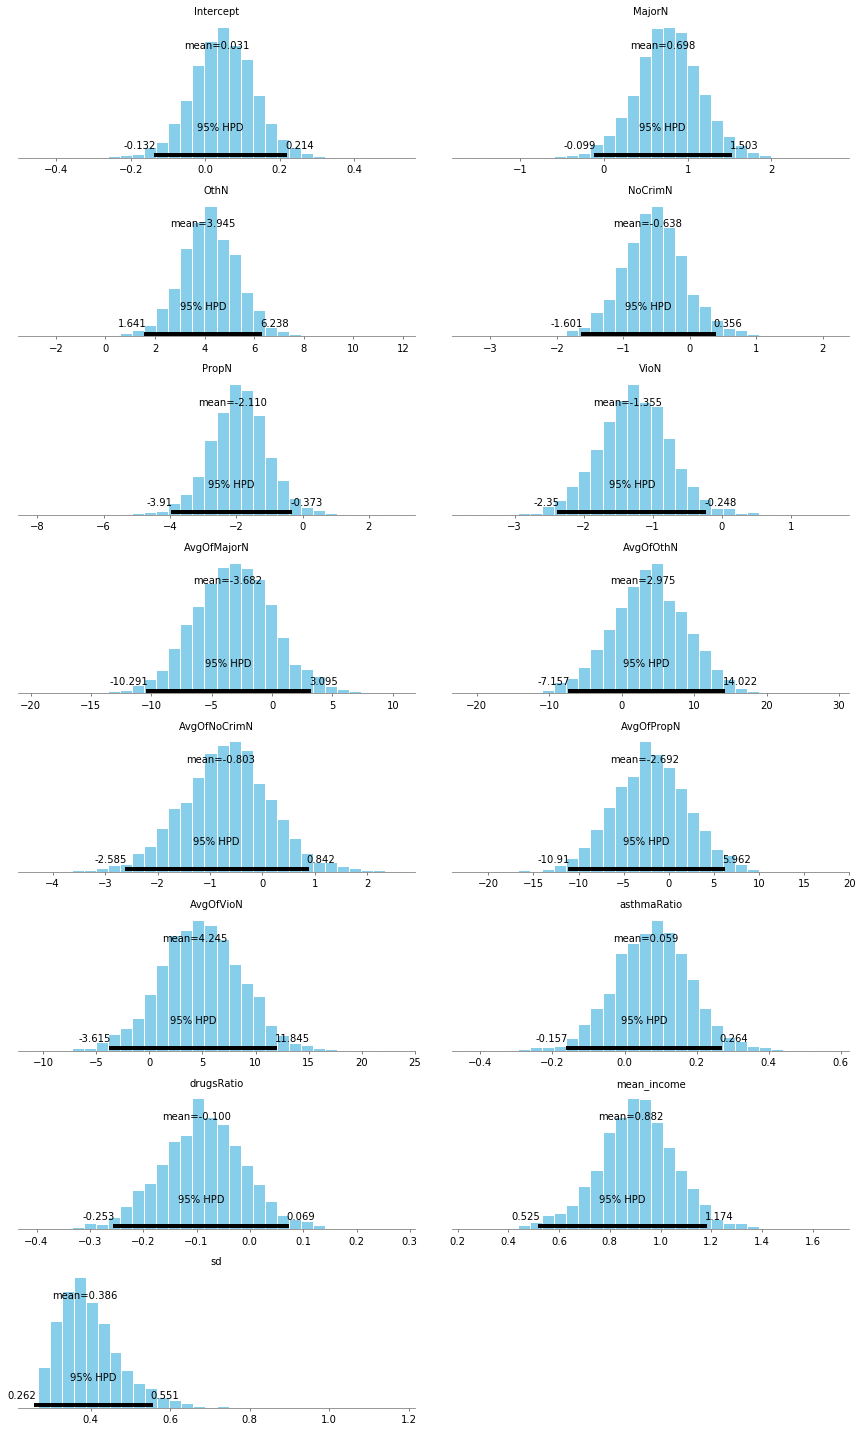

In [29]:
pm.plot_posterior(normal_trace)

In [31]:
pm.summary(normal_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,0.031346,0.087536,0.001913,-0.131871,0.214040,2297.684808,0.999849
MajorN,0.698421,0.402120,0.011226,-0.098919,1.503218,1252.761361,1.001358
OthN,3.945422,1.177442,0.034254,1.641432,6.237956,1120.056220,1.000973
NoCrimN,-0.638099,0.491684,0.013501,-1.601238,0.356085,1208.878842,1.000516
PropN,-2.110050,0.894838,0.025836,-3.910068,-0.373463,1106.658198,1.001955
VioN,-1.355173,0.529274,0.014892,-2.349585,-0.248494,1269.634942,1.000225
AvgOfMajorN,-3.682485,3.375070,0.104061,-10.291010,3.095094,1100.330678,0.999839
AvgOfOthN,2.974997,5.338402,0.159293,-7.157223,14.021682,1149.163981,1.000508
AvgOfNoCrimN,-0.802570,0.867199,0.021871,-2.584994,0.842010,1458.667127,1.001678
AvgOfPropN,-2.691751,4.265403,0.127780,-10.910429,5.962011,1159.289439,1.000305


In [32]:
def model_effect(query_var, trace, X):
    
    # Variables that do not change
    steady_vars = list(X.columns)
    steady_vars.remove(query_var)
    
    # Linear Model that estimates a grade based on the value of the query variable 
    # and one sample from the trace
    def lm(value, sample):
        
        # Prediction is the estimate given a value of the query variable
        prediction = sample['Intercept'] + sample[query_var] * value
        
        # Each non-query variable is assumed to be at the median value
        for var in steady_vars:
            
            # Multiply the weight by the median value of the variable
            prediction += sample[var] * X[var].median()
        
        return prediction
    
    figsize(6, 6)
    
    # Find the minimum and maximum values for the range of the query var
    var_min = X[query_var].min()
    var_max = X[query_var].max()
    
    # Plot the estimated grade versus the range of query variable
    pm.plot_posterior_predictive_glm(trace, eval=np.linspace(var_min, var_max, 100), 
                                     lm=lm, samples=100, color='blue', 
                                     alpha = 0.4, lw = 2)
    
    # Plot formatting
    plt.xlabel('%s' % query_var, size = 16)
    plt.ylabel('SATall', size = 16)
    plt.title("Posterior of SATall vs %s" % query_var, size = 18)
    plt.show()

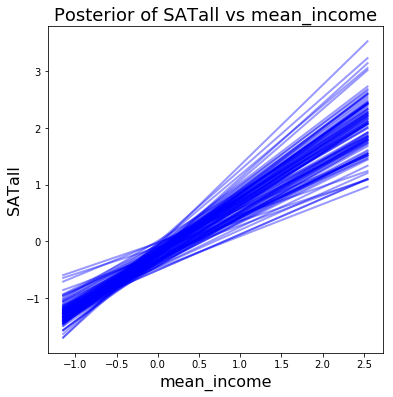

In [33]:
model_effect('mean_income', normal_trace, X_train.drop(columns='SATall'))

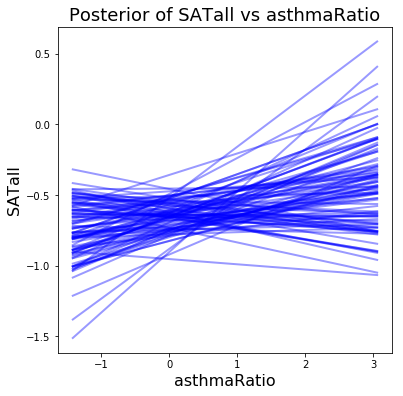

In [34]:
model_effect('asthmaRatio', normal_trace, X_train.drop(columns='SATall'))

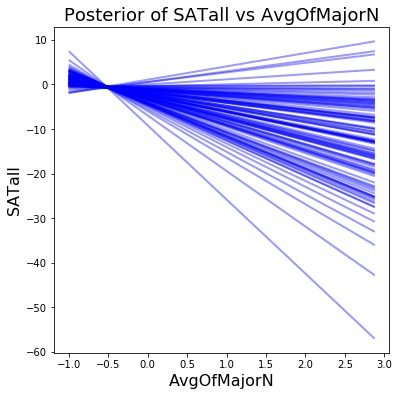

In [35]:
model_effect('AvgOfMajorN', normal_trace, X_train.drop(columns='SATall'))

In [71]:
import seaborn as sns
def test_model_t(trace, test_observation):
    
    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]

    # Results into a dataframe
    var_weights = pd.DataFrame(var_dict)

    # Actual Value
    actual = test_observation['SATall']
    
    # Add in intercept term
    test_observation['Intercept'] = 1
    test_observation = test_observation.drop('SATall')
    
    # Align weights and test observation
    var_weights = var_weights[test_observation.index]

    # Means for all the weights
    var_means = var_weights.mean(axis=0)

    # Location of mean for observation
    mean_loc = np.dot(var_means, test_observation)
    print(mean_loc)
    
    # Estimates of grade
    estimates = mean_loc + np.random.standard_t(df = 2, size = 1000)

    plt.figure(figsize(8, 8))
    sns.distplot(estimates, hist = True, kde = True, bins = 19,
                 hist_kws = {'edgecolor': 'k', 'color': 'darkblue'},
                kde_kws = {'linewidth' : 4},
                label = 'Estimated Dist.')
    plt.vlines(x = actual,  ymin = 0, ymax = 0.4,
               linestyles = '--', colors = 'red',
               label = 'True Grade',
              linewidth = 2.5)
    plt.vlines(x = mean_loc, ymin = 0, ymax = 0.4, 
               linestyles = '-', colors = 'orange',
               label = 'Mean Estimate',
              linewidth = 2.5)
    
    plt.legend(loc = 1)
    plt.title('Density Plot for Test Observation');
    plt.xlabel('SATall'); plt.ylabel('Density');
    
    print('True SATall = %d' % actual)
    print('Average Estimate = %0.4f' % mean_loc)
    print('5%% Estimate = %0.4f    95%% Estimate = %0.4f' % (np.percentile(estimates, 5),
                                       np.percentile(estimates, 95)))

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


0.961018335437
True SATall = 0
Average Estimate = 0.9610
5% Estimate = -2.3132    95% Estimate = 3.4162


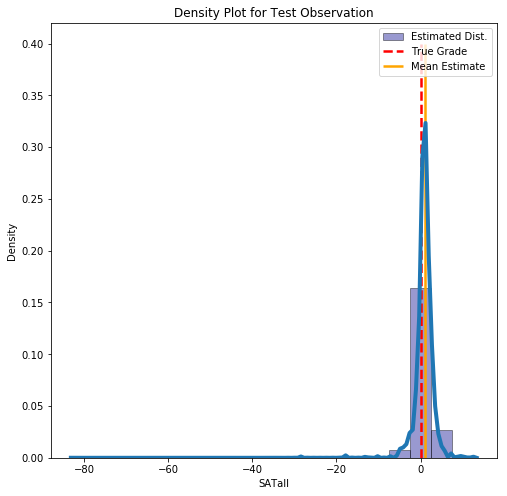

In [72]:
test_model_t(normal_trace, X_test.iloc[7])

In [105]:

# Evalute the MCMC trace and compare to ml models
def evaluate_trace(trace, X_train, X_test, y_train, y_test, model_results):
    
    # Dictionary of all sampled values for each parameter
    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]
    
    
    # Results into a dataframe
    var_weights = pd.DataFrame(var_dict)
    
    # Means for all the weights
    var_means = var_weights.mean(axis=0)
   
    
    # Create an intercept column
    X_test['Intercept'] = 1
    
    # Align names of the test observations and means
    names = X_test.columns[1:]
    X_test = X_test.ix[:, names]
   
    var_means = var_means[names]

    # Calculate estimate for each test observation using the average weights
    results = pd.DataFrame(index = X_test.index, columns = ['estimate'])
    

    for row in X_test.iterrows():
        
        results.ix[row[0], 'estimate'] = np.dot(np.array(var_means), np.array(row[1]))
    
        
    # Metrics 
    actual = np.array(y_test)
    errors = results['estimate'] - actual
    mae = np.mean(abs(errors))
    rmse = np.sqrt(np.mean(errors ** 2))
    
    print('Model  MAE: {:.4f}\nModel RMSE: {:.4f}'.format(mae, rmse))
    
    # Add the results to the comparison dataframe
    model_results.ix['Bayesian LR', :] = [mae, rmse]
    
    
    return model_results

In [129]:
all_model_results = evaluate_trace(normal_trace, X_train, X_test.drop(columns='SATall'), y_train, y_test, results)

Model  MAE: 0.9145
Model RMSE: 1.0518


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:23: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:33: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:45: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [103]:
X_test

,MajorN,OthN,NoCrimN,PropN,VioN,AvgOfMajorN,AvgOfOthN,AvgOfNoCrimN,AvgOfPropN,AvgOfVioN,asthmaRatio,drugsRatio,SATall,mean_income,Intercept
35,-0.648621,-0.877441,-0.749731,-0.745546,-0.849472,-0.037284,0.048405,0.007957,0.060717,0.004110,-0.090844,0.752784,0.539247,-0.358188,1
13,-0.235523,-0.283365,-0.033732,-0.319250,-0.187395,0.333289,0.000840,-0.052478,0.003263,0.274575,-1.203288,-0.649164,1.588423,2.809194,1
26,1.086389,1.763089,2.060371,0.565944,2.479828,1.950213,2.216651,1.982882,2.180453,2.003838,-0.036070,-0.700892,1.816237,-0.238774,1
30,1.086389,-0.086916,0.446978,0.053709,0.445256,0.428820,0.324637,0.225100,0.347626,0.377013,-1.348519,-0.641658,-0.289449,0.122720,1
16,2.077823,4.025203,4.319710,3.830394,3.211265,1.742265,1.012714,1.165877,1.066569,1.795849,-0.026751,-0.638498,0.452875,-0.193414,1
31,1.086389,0.706631,1.118914,1.003669,0.684719,1.372152,1.140486,1.112822,1.173441,1.327901,-0.212424,-0.405495,1.102850,-0.099676,1
21,-0.896479,-0.715304,-0.686744,-0.680665,-0.849472,-0.840192,-0.496439,-0.519680,-0.466415,-0.852244,-0.031900,-0.701915,-0.899661,-0.006167,1
12,-0.455842,-0.707695,-0.665007,-0.546526,-0.672918,-0.632245,-0.562577,-0.568739,-0.580974,-0.611213,-1.231253,0.394590,0.205600,1.795056,1
8,0.094955,0.353049,-0.084172,0.467755,0.209851,0.005562,-0.403544,-0.406877,-0.377554,-0.055783,0.909287,0.824744,-0.620123,-0.391955,1


In [110]:
# Calculate mae and rmse
def evaluate_predictions(predictions, true):
    mae = np.mean(abs(predictions - true))
    rmse = np.sqrt(np.mean((predictions - true) ** 2))
    
    return mae, rmse

In [111]:
# Naive baseline is the median
median_pred = X_train['SATall'].median()
median_preds = [median_pred for _ in range(len(X_test))]
true = X_test['SATall']
# Display the naive baseline metrics
mb_mae, mb_rmse = evaluate_predictions(median_preds, true)
print('Median Baseline  MAE: {:.4f}'.format(mb_mae))
print('Median Baseline RMSE: {:.4f}'.format(mb_rmse))

Median Baseline  MAE: 1.0496
Median Baseline RMSE: 1.2925


In [125]:
# Evaluate several ml models by training on training set and testing on testing set
def evaluate(X_train, X_test, y_train, y_test):
    # Names of models
    model_name_list = ['Linear Regression', 'ElasticNet Regression',
                      'Random Forest', 'Extra Trees', 'SVM',
                       'Gradient Boosted', 'Baseline']
    X_train = X_train.drop(columns='SATall')
    print(X_train.shape)
    X_test = X_test.drop(columns=['SATall', 'Intercept'])
    print(X_test.shape)
    
    # Instantiate the models
    model1 = LinearRegression()
    model2 = ElasticNet(alpha=1.0, l1_ratio=0.5)
    model3 = RandomForestRegressor(n_estimators=50)
    model4 = ExtraTreesRegressor(n_estimators=50)
    model5 = SVR(kernel='rbf', degree=3, C=1.0, gamma='auto')
    model6 = GradientBoostingRegressor(n_estimators=20)
    
    # Dataframe for results
    results = pd.DataFrame(columns=['mae', 'rmse'], index = model_name_list)
    
    # Train and predict with each model
    for i, model in enumerate([model1, model2, model3, model4, model5, model6]):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        # Metrics
        mae = np.mean(abs(predictions - y_test))
        rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
        
        # Insert results into the dataframe
        model_name = model_name_list[i]
        results.ix[model_name, :] = [mae, rmse]
    
    # Median Value Baseline Metrics
    baseline = np.median(y_train)
    baseline_mae = np.mean(abs(baseline - y_test))
    baseline_rmse = np.sqrt(np.mean((baseline - y_test) ** 2))
    
    results.ix['Baseline', :] = [baseline_mae, baseline_rmse]
    
    return results

In [126]:
results = evaluate(X_train, X_test, y_train, y_test)

(27, 13)
(9, 13)


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:34: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:34: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:34: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/usr/local/An

In [128]:
results

,mae,rmse
Linear Regression,0.843727,1.04198
ElasticNet Regression,0.797423,0.952053
Random Forest,0.692423,0.82839
Extra Trees,0.598698,0.718554
SVM,0.427501,0.582024
Gradient Boosted,0.741087,0.893718
Baseline,1.04958,1.29254


In [130]:
all_model_results 

,mae,rmse
Linear Regression,0.843727,1.04198
ElasticNet Regression,0.797423,0.952053
Random Forest,0.692423,0.82839
Extra Trees,0.598698,0.718554
SVM,0.427501,0.582024
Gradient Boosted,0.741087,0.893718
Baseline,1.04958,1.29254
Bayesian LR,0.914465,1.05177


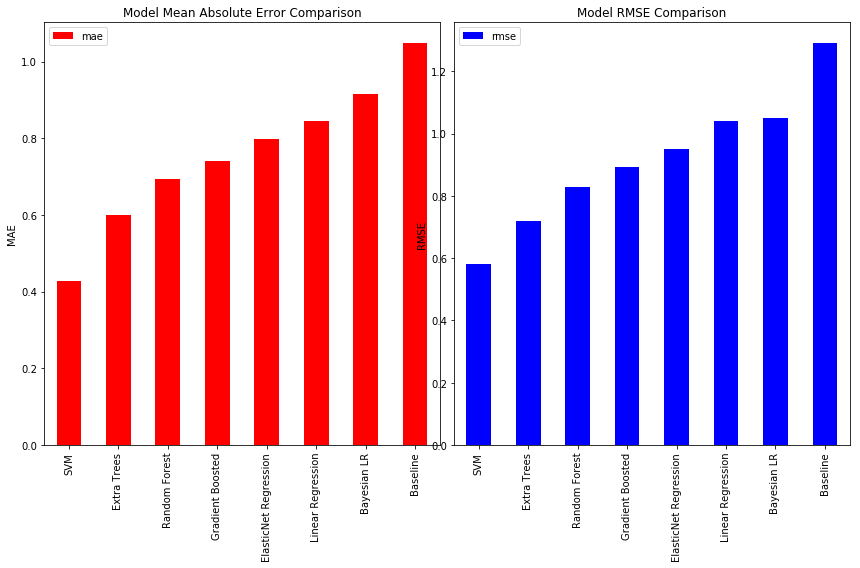

In [131]:
plt.figure(figsize=(12, 8))
    
    # Plot median absolute percentage error of all models
ax = plt.subplot(1, 2, 1)
all_model_results.sort_values('mae', ascending = True).plot.bar(y = 'mae', color = 'r', ax = ax)
plt.title('Model Mean Absolute Error Comparison'); plt.ylabel('MAE'); 
plt.tight_layout()
    
    # Plot root mean squared error of all models
ax = plt.subplot(1, 2, 2)
all_model_results.sort_values('rmse', ascending = True).plot.bar(y = 'rmse', color = 'b', ax = ax)
plt.title('Model RMSE Comparison'); plt.ylabel('RMSE')